# Some attempt at Particle Tracking

In [325]:
# Importing things

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq
from scipy.fft import fft, fftfreq

from lab_functions import *

In [326]:
# where is the data?
loc = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/2024-03-11/'
filename = 'Results.csv'

# read in as dataframe
df = pd.read_csv(loc + filename)

# select x and y positions of bead for all 83 frames
# get rid of anomalous last point
x = np.array(df['x'])[:-1]
y = np.array(df['y'])[:-1]

In [327]:
# Conversion Factor
pixels_microns = 15.36
pm_err = 0.5

x_mic = x*(1/pixels_microns)
y_mic = y*(1/pixels_microns)

x_mic_err = np.abs(x*(1/(pixels_microns+pm_err)) - x*(1/pixels_microns))
y_mic_err = np.abs(y*(1/(pixels_microns+pm_err)) - y*(1/pixels_microns))

Text(0.5, 1.0, 'Particle Tracks over 3 Seconds \n NB Errors on this plot only include uncertainties from \n varying frame rate')

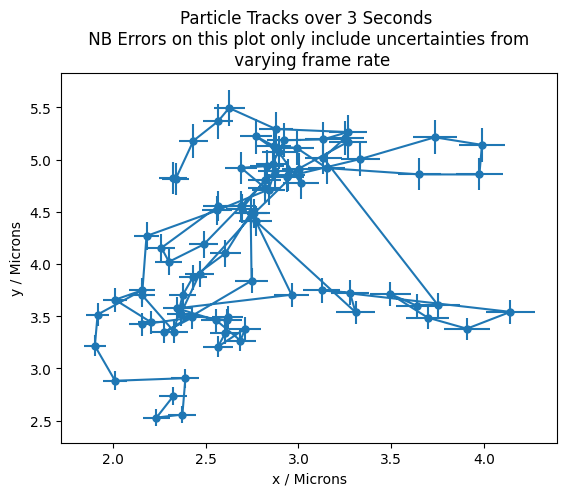

In [328]:
# Plot x and y trajectory

plt.errorbar(x_mic,y_mic, yerr = y_mic_err, xerr = x_mic_err, ms = 5, fmt = 'o', linestyle = '-')
plt.xlabel('x / Microns')
plt.ylabel('y / Microns')
plt.title('Particle Tracks over 3 Seconds \n NB Errors on this plot only include uncertainties from \n varying frame rate')

Text(0, 0.5, 'Position / Microns')

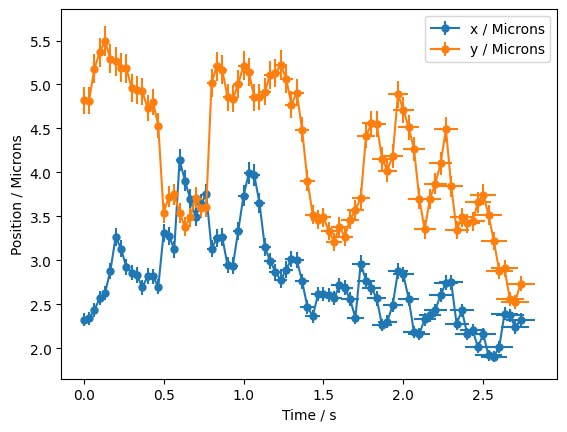

In [329]:
# Frames per second on camera
fps = 30
fps_err = 1

# Set time axis in seconds
time = np.arange(x.size) / 30
time_err = np.arange(x.size) * np.abs(1/31 - 1/30) # fps error is 1

# plot x and y over time
plt.errorbar(time,x_mic, xerr = time_err, yerr = x_mic_err, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic, xerr = time_err, yerr = y_mic_err, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position / Microns')

Text(0.5, 1.0, 'Particle Position with Time')

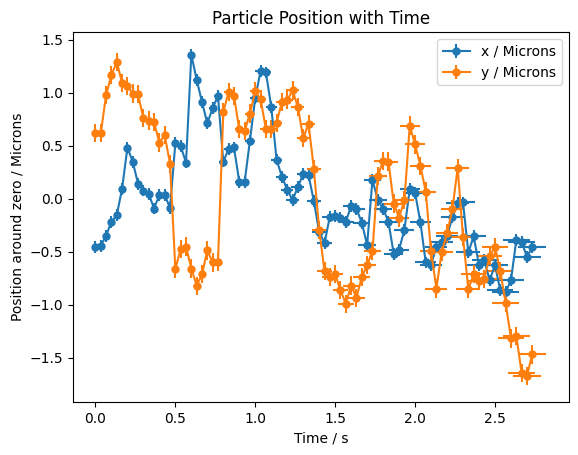

In [330]:
# Find mean of particle tracks to centre data on zero
x_mean = np.mean(x_mic)
y_mean = np.mean(y_mic)

# Error on mean = standard error
x_stderr = np.std(x_mic) / np.sqrt(len(x_mic))
y_stderr = np.std(y_mic) / np.sqrt(len(y_mic))

# Subtract mean from data
x_mic0 = x_mic - x_mean
y_mic0 = y_mic - y_mean

# Errors
x_mic0_err = np.abs( (x_mic - (x_mean+x_stderr)) - (x_mic - x_mean) )
y_mic0_err = np.abs( (y_mic - (y_mean+y_stderr)) - (y_mic - y_mean) )

# plot x and y over time
plt.errorbar(time,x_mic0, xerr = time_err, yerr = x_mic0_err, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic0, xerr = time_err, yerr = y_mic0_err, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position around zero / Microns')
plt.title('Particle Position with Time')

In [331]:
def fourier_calc(data, sample_number):

    # Compute transform and normalise by length / 2
    fast_four = rfft(data, n = sample_number) / (len(data) / 2)

    # Compute amplitude squared and divide by measurement time
    ps = np.abs(fast_four)**2 / time[-1]

    # Calculate frequency components (is the sample spacing right?)
    freq = rfftfreq(sample_number, d=1.0/fps)

    return ps, freq

Consider Error on Particle Tracking Centre as dominant from now on

In [332]:
# Look at error in particle

# Radius of Beads
radius = 2.56e-6 / 2 # in metres
radius_err = 0.01e-6 / 2

Text(0.5, 1.0, 'Convergence on X')

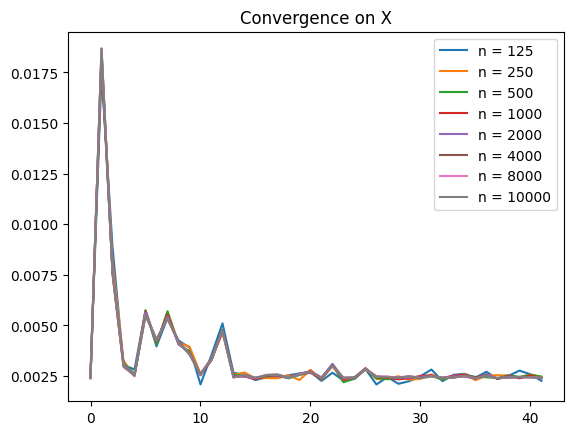

In [333]:
# Use random error simulation

# Generate power spectrum
ps, freq = fourier_calc(x_mic0, x_mic0.size)
psy, freqy = fourier_calc(y_mic0, y_mic0.size)

# Empty list for errors
many_errs = []
many_errsf = []
mean_errs = []
mean_errsf = []

# How many interations?
n = np.array([125,250,500,1000,2000,4000,8000,10000])

for j in range(n.size):

    # Loop to do random distribution many times
    for i in range(n[j]):

        # random distribution of number between plus/minus 1/2 particle radius
        rand_dist = (np.random.rand(x_mic0.size)*2*radius*1e6 - radius*1e6)*(1/2)

        # Generate power spectrum with random error
        ps_rand, freq_rand = fourier_calc(x_mic0 + rand_dist, x_mic0.size)

        # Find difference in power spectrum
        ps_err_rand = np.abs(ps - ps_rand)
        freq_err_rand = np.abs(freq - freq_rand)

        # Add to big list
        many_errs.append(ps_err_rand)
        many_errsf.append(freq_err_rand)

    # Take the mean of the iterations
    ps_err_lots = np.mean(np.array(many_errs), axis = 0)
    freq_err_lots = np.mean(np.array(many_errsf), axis = 0)

    # Add to a big list
    mean_errs.append(ps_err_lots)
    mean_errsf.append(freq_err_lots)

    # Plot to see convergence behaviour
    plt.plot(np.arange(np.size(mean_errs[j])), mean_errs[j], label = 'n = {}'.format(n[j]), ms = 5)

plt.legend()
plt.title('Convergence on X')

Text(0.5, 1.0, 'Convergence on Y')

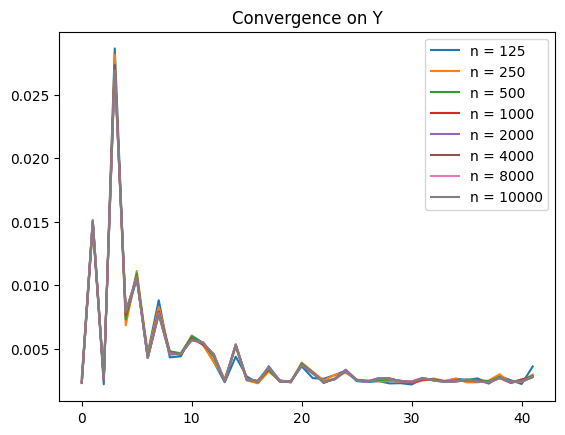

In [334]:
# Empty list for errors
many_errsy = []
mean_errsy = []

for j in range(n.size):

    # Loop to do random distribution many times
    for i in range(n[j]):

        # random distribution of number between plus/minus 1/2 particle radius
        rand_disty = (np.random.rand(y_mic0.size)*2*radius*1e6 - radius*1e6)*(1/2)

        # Generate power spectrum with random error
        ps_randy, freq_randy = fourier_calc(y_mic0 + rand_disty, y_mic0.size)

        # Find difference in power spectrum
        ps_err_randy = np.abs(psy - ps_randy)

        # Add to big list
        many_errsy.append(ps_err_randy)

    # Take the mean of the iterations
    ps_err_lotsy = np.mean(np.array(many_errsy), axis = 0)

    # Add to a big list
    mean_errsy.append(ps_err_lotsy)

    # Plot to see convergence behaviour
    plt.plot(np.arange(np.size(mean_errsy[j])), mean_errsy[j], label = 'n = {}'.format(n[j]), ms = 5)

plt.legend()
plt.title('Convergence on Y')

In [335]:
''' Take error on power spectrum to be the erros generated from 10,000 random iterations'''
ps_err = mean_errs[-1]
freq_err = mean_errsf[-1]

ps_erry = mean_errsy[-1]

Text(0, 0.5, 'Fourier Transform Squared / Arb Units')

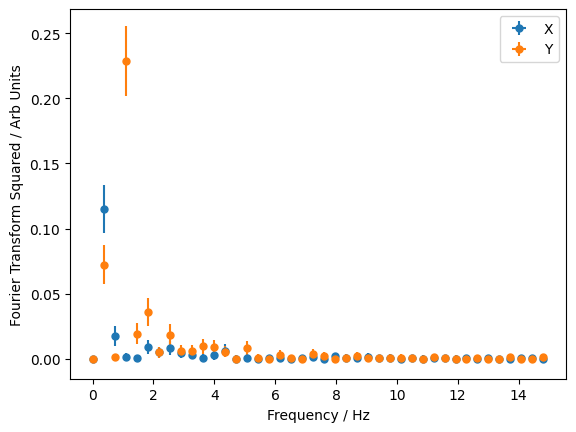

In [336]:
# Plot using above function
plt.errorbar(freq, ps, xerr = freq_err, yerr = ps_err, ms = 5, fmt = 'o', linestyle = '',label = 'X')
plt.errorbar(freqy, psy, xerr = freq_err, yerr = ps_erry, ms = 5, fmt = 'o', linestyle = '',label = 'Y')
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Fourier Transform Squared / Arb Units')

In [337]:
# try getting rid of first data point
# point = 0
# freq = np.delete(freq,point)
# freq_err = np.delete(freq_err,point)
# ps = np.delete(ps,point)
# ps_err = np.delete(ps_err,point)

print(freq_err.size, ps_err.size)

# Make errorbars the right shape to only see upper bars
ps_err_upper = np.zeros([2,ps_err.size])
ps_err_upper[1,:] = ps_err

ps_errs_trunc = np.zeros([2,ps_err.size])
ps_errs_trunc[1,:] = ps_err
ps_errs_trunc[0,:] = np.abs(ps - 0.5*1e-7) # so that graph looks neater
ps_errs_truncy = np.zeros([2,ps_erry.size])
ps_errs_truncy[1,:] = ps_erry
ps_errs_truncy[0,:] = np.abs(psy - 0.5*1e-7) # so that graph looks neater

42 42


C:\Users\abiga\AppData\Local\Temp\ipykernel_22548\2043525069.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8,0)


(1e-08, 8.203214463072182)

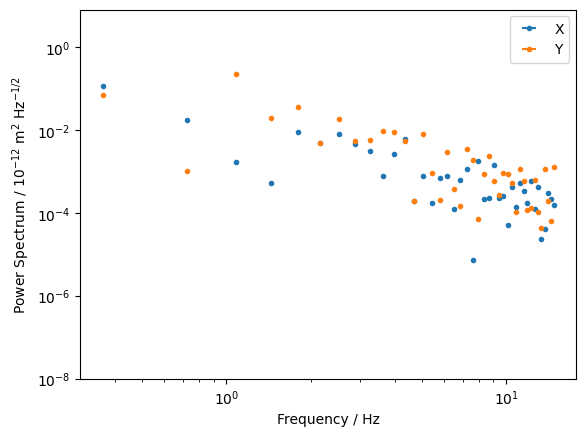

In [338]:
# Use a log scale
plt.errorbar(freq, ps, xerr = freq_err, label = 'X', linestyle = '', marker = 'o', ms = 3)
plt.errorbar(freqy, psy, xerr = freq_err, label = 'Y', linestyle = '', marker = 'o', ms = 3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
plt.ylim(1e-8,0)

In [339]:
# Fit the above to Lorenzian Power Spectrum

def Lorentzian(x,A,f_0):
    return A / ((1 + x/f_0)**2)

ig = np.array([0.12,0.1])

# Fits to different errors in fit
yfit, parameters, perrors, chisq_reduced, p_value, dof = fit_labs(freq,ps,ps_err,Lorentzian,ig)
yfity, parametersy, perrorsy, chisq_reducedy, p_valuey, dofy = fit_labs(freqy,psy,ps_erry,Lorentzian,ig)
#yfitb, parametersb, perrorsb, chisq_reducedb, p_valueb, dofb = fit_labs(freq,ps,ps_err,Lorentzian,ig)

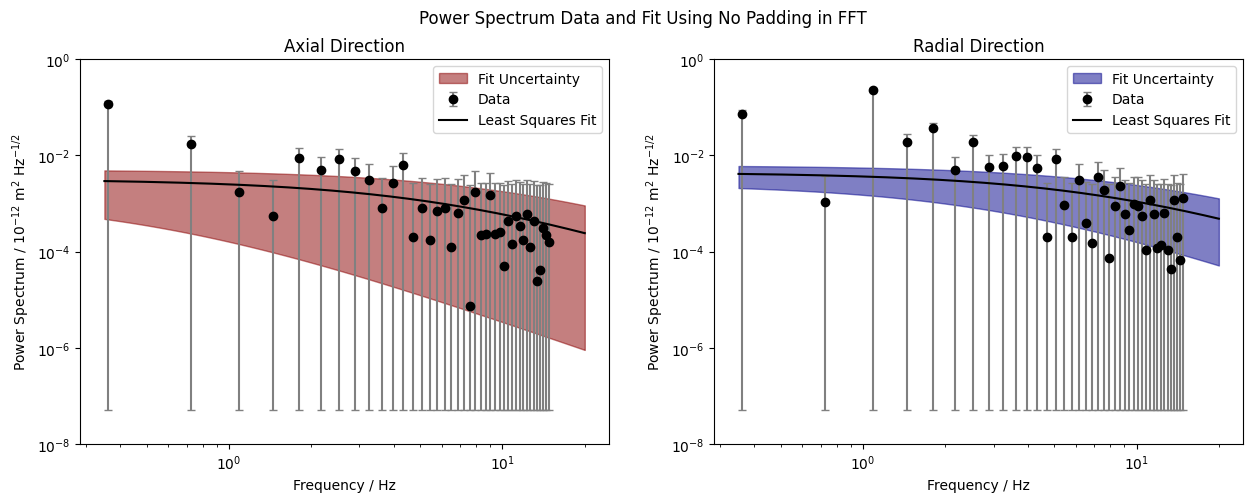

In [346]:
# Plot with Fit
# Use a log scale

fig, (ax2,ax1) = plt.subplots(1,2, figsize = (15,5))

some_fs = np.linspace(0.35,20,1000)

fig.suptitle('Power Spectrum Data and Fit Using No Padding in FFT')

# Axis 2 - X - axial direction
ax2.errorbar(freq, ps, yerr = ps_errs_trunc, label = 'Data', linestyle = '', marker = 'o', color = 'k', ecolor = 'grey', capsize = 3)
ax2.errorbar(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Least Squares Fit', linestyle = '-', color = 'black')

ax2.fill_between(some_fs, Lorentzian(some_fs,parameters[0]+perrors[0],parameters[1]+perrors[1]), Lorentzian(some_fs,parameters[0]-perrors[0],parameters[1]-perrors[1]),
                 color = 'darkred', alpha = 0.5, label = 'Fit Uncertainty')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax2.set_xlabel('Frequency / Hz')
ax2.set_ylim(1e-8,1)
ax2.set_title('Axial Direction')
ax2.legend()

# Axis 1 - Y - Radial Direction
ax1.errorbar(freqy, psy, yerr = ps_errs_truncy, label = 'Data', linestyle = '', marker = 'o', color = 'k', ecolor = 'grey', capsize = 3)
ax1.errorbar(some_fs, Lorentzian(some_fs,parametersy[0],parametersy[1]), label = 'Least Squares Fit', linestyle = '-', color = 'black')

ax1.fill_between(some_fs, Lorentzian(some_fs,parametersy[0]+perrorsy[0],parametersy[1]+perrorsy[1]), Lorentzian(some_fs,parametersy[0]-perrorsy[0],parametersy[1]-perrorsy[1]),
                 color = 'darkblue', alpha = 0.5, label = 'Fit Uncertainty')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax1.set_xlabel('Frequency / Hz')
ax1.set_ylim(1e-8,1)
ax1.set_title('Radial Direction')
ax1.legend()

In [341]:
# Print Results

print('FOR X - Axial Direction')
print('The Amplitude of the Lorentzian is {} pm {} 10^-12 m$^2$ Hz^-1/2$'.format(parameters[0], perrors[0]))
print('The Cutoff Frequency is {} pm {} Hz'.format(parameters[1], perrors[1]))
print('The reduced chi squared value for the fit is {}'.format(chisq_reduced))
print('  ')
print('FOR Y - Radial Direction')
print('The Amplitude of the Lorentzian is {} pm {} 10^-12 m$^2$ Hz^-1/2$'.format(parametersy[0], perrorsy[0]))
print('The Cutoff Frequency is {} pm {} Hz'.format(parametersy[1], perrorsy[1]))
print('The reduced chi squared value for the fit is {}'.format(chisq_reducedy))

FOR X - Axial Direction
The Amplitude of the Lorentzian is 0.003199545378979783 pm 0.0019068373606372403 10^-12 m$^2$ Hz^-1/2$
The Cutoff Frequency is 7.5853112124626705 pm 7.041344842160209 Hz
The reduced chi squared value for the fit is 1.2227492047501447
  
FOR Y - Radial Direction
The Amplitude of the Lorentzian is 0.004415352161878083 pm 0.0018529503378040054 10^-12 m$^2$ Hz^-1/2$
The Cutoff Frequency is 9.881562949998253 pm 6.577907397239028 Hz
The reduced chi squared value for the fit is 3.0749366738627835


In [342]:
# Calculate the key parameters

# ROUGHLY 1.5 centi Poise 
# https://corecheminc.com/ethylene-glycol-water-mixture-properties/
eta = 1.5e-3 # Pa s
eta_err = 0.1e-3

# Boltzmanns const
k_b = 1.38e-23
# Temperature
T = 273+20
T_err = 5

# Caclulate stokes drag constant
beta = 6*np.pi*eta*radius

# Beta errors 
eta_cont = np.abs(6*np.pi*(eta+eta_err)*radius - 6*np.pi*eta*radius)
rad_cont = np.abs(6*np.pi*eta*(radius+radius_err) - 6*np.pi*eta*radius)
beta_err = np.sqrt(eta_cont**2 + rad_cont**2)

# Use cutoff freq to find stiffness constant, kappa
f0 = parameters[1]
f0_err = perrors[1]
stiffness = 2*np.pi*beta*f0

f0y = parametersy[1]
f0_erry = perrorsy[1]
stiffnessy = 2*np.pi*beta*f0y

# Kappa Errors

beta_cont = np.abs(2*np.pi*(beta+beta_err)*f0 - 2*np.pi*beta*f0)
f0_cont = np.abs(2*np.pi*beta*(f0+f0_err) - 2*np.pi*beta*f0)
stiffness_err = np.sqrt(beta_cont**2 + f0_cont**2)

beta_conty = np.abs(2*np.pi*(beta+beta_err)*f0y - 2*np.pi*beta*f0y)
f0_conty = np.abs(2*np.pi*beta*(f0y+f0_erry) - 2*np.pi*beta*f0y)
stiffness_erry = np.sqrt(beta_cont**2 + f0_conty**2)

print('The Stiffness Constant for X is k = {} pm {} micro N m^-1'.format(stiffness*1e6, stiffness_err*1e6))
print('The Stiffness Constant for Y is k = {} pm {} micro N m^-1'.format(stiffnessy*1e6, stiffness_erry*1e6))

The Stiffness Constant for X is k = 1.7248670421385888 pm 1.6053094181438474 micro N m^-1
The Stiffness Constant for Y is k = 2.2470247798489567 pm 1.5002164460781942 micro N m^-1


In [343]:
# Trapping Force - kx

''' Use standard deviation as delta x?'''
delta_x = np.std(x_mic0) * 1e-6 # CONVERT TO METRES
force = stiffness*delta_x
force_err = stiffness_err*delta_x

delta_y = np.std(y_mic0) * 1e-6 # CONVERT TO METRES
forcey = stiffnessy*delta_y
force_erry = stiffness_erry*delta_y

print('The force for X is {} pm {} pN'.format(force*1e12,force_err*1e12))
print('The force for Y is {} pm {} pN'.format(forcey*1e12,force_erry*1e12))

The force for X is 0.8724305950742435 pm 0.8119588447890326 pN
The force for Y is 1.7580109951987335 pm 1.1737284924649192 pN


In [344]:
# F = QnP / c
# so Q = Fc / nP

power = 1e-3 # in watts
power_err = 1e-3
n = 1.38805 # see https://pubs.acs.org/doi/10.1021/je900630n 
c = 3e8

Q = force*c / n*power
Qy = forcey*c / n*power

# Error on Q - not including n or c
power_cont = np.abs( (force*c / n*(power+power_err)) - (force*c / n*power) )
force_cont = np.abs( ((force+force_err)*c / n*power) - (force*c / n*power) )
Q_err = np.sqrt(force_cont**2 + power_cont**2)

power_conty = np.abs( (forcey*c / n*(power+power_err)) - (forcey*c / n*power) )
force_conty = np.abs( ((forcey+force_erry)*c / n*power) - (forcey*c / n*power) )
Q_erry = np.sqrt(force_conty**2 + power_conty**2)

print('The Trapping Efficiency Q in the X direction is {} pm {}'.format(Q,Q_err))
print('The Trapping Efficiency Q in the Y direction is {} pm {}'.format(Qy,Q_erry))
print('')
print('With error included, this is essentially zero')

The Trapping Efficiency Q in the X direction is 1.885588981104953e-07 pm 2.575866540491899e-07
The Trapping Efficiency Q in the Y direction is 3.7995987072484424e-07 pm 4.5686138313559834e-07

With error included, this is essentially zero
